# Etapa 1. Construcción de modelos de analítica de textos

## Introducción

En el marco de la Agenda 2030 para el Desarrollo Sostenible, la participación ciudadana se ha convertido en un eje fundamental para identificar problemáticas sociales y orientar las políticas públicas hacia el cumplimiento de los Objetivos de Desarrollo Sostenible (ODS). Sin embargo, el análisis de grandes volúmenes de información textual proveniente de opiniones ciudadanas representa un desafío por la complejidad y los recursos que demanda.

Este trabajo tiene como propósito construir un modelo de analítica de textos que permita clasificar automáticamente las opiniones de los habitantes locales en relación con los ODS 1 (Fin de la pobreza), 3 (Salud y bienestar) y 4 (Educación de calidad). Para ello, se seguirá un proceso propio de la ciencia de datos, que incluye el entendimiento y preparación de los datos, la construcción del modelo analítico, y su evaluación tanto cuantitativa como cualitativa. Con esta propuesta se busca facilitar la interpretación de la voz ciudadana y contribuir a la toma de decisiones más informadas en el contexto del desarrollo sostenible.

### Objetivo:

- Aplicar  la  metodología  de  analítica  de  textos  para  la  construcción  de  soluciones  de analítica alineadas con los objetivos de organizaciones en un contexto de aplicación

(python=3.11)

## Librerias

In [1]:
!pip install pandas
!pip install openpyxl
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install spacy==3.7.2
!pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.7.0/es_core_news_sm-3.7.0-py3-none-any.whl
!pip install scikit-learn
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 12.6 MB/s eta 0:00:0031m12.7 MB/s eta 0:00:01


In [2]:
import pandas as pd
# Graficos.........................................................
import matplotlib.pyplot as plt
import seaborn as sns
# Procesamiento de lenguaje natural (NLP)..........................
import nltk
import re 

In [3]:
import spacy

In [4]:
from nltk.corpus import stopwords
# Preparacion .....................................................
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Modelado .........................................................
from sklearn.calibration import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
# Evaluacion .......................................................
from sklearn.metrics import classification_report, confusion_matrix

## Carga y exploración inicial

In [5]:
file_path = 'data/Datos_proyecto.xlsx'

try:
    df = pd.read_excel(file_path)
    print("------------------------------------------")
    print("¡Archivo cargado exitosamente!")
    print("------------------------------------------")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{file_path}'.")
    df = pd.DataFrame()


if not df.empty:
    
    # Vistazo a las primeras 5 filas
    print("\n--- Primeras 5 filas de los datos: ---")
    display(df.head())
    
    # Obtener un resumen del DataFrame.
    print("------------------------------------------")
    print("\n--- Información general del DataFrame: ---")
    df.info()


------------------------------------------
¡Archivo cargado exitosamente!
------------------------------------------

--- Primeras 5 filas de los datos: ---


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


------------------------------------------

--- Información general del DataFrame: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


/var/folders/px/d5tv6q6n34qgfy_7vn7yfql80000gn/T/ipykernel_33092/2456759891.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='labels', palette="viridis",


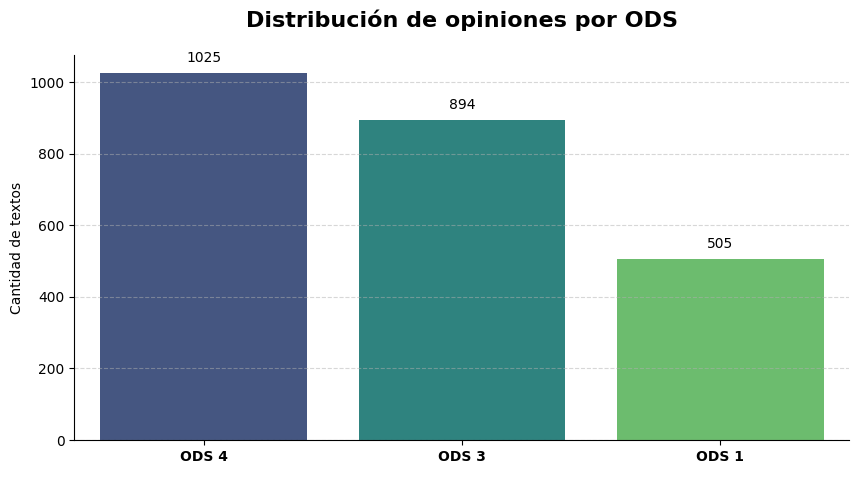

In [6]:
# Tamaño del grafico (x,y)................................................................
plt.figure(figsize=(10,5)) 
# Grafico.................................................................................
plt.ticklabel_format(style='plain', axis='y')  #Evita la notacion cientifica en el eje Y
ax = sns.countplot(data=df, x='labels', palette="viridis",
                   order=df['labels'].value_counts().index
)

# Estilo del grafico......................................................................
plt.title('Distribución de opiniones por ODS', fontsize=16, loc="center",fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Cantidad de textos')
plt.xticks(ticks=[0, 1, 2], labels=['ODS 4', 'ODS 3', 'ODS 1'],fontweight='bold')
sns.despine()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

for container in ax.containers:
    ax.bar_label(container, padding=6)

## Entendimiento y preparación de los datos

In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/renegade/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/renegade/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import re
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("es_core_news_sm")
stop_words = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar signos de puntuación y números
    texto = re.sub(r'[^a-záéíóúñü]', ' ', texto)
    # Quitar espacios repetidos y al inicio/final
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    doc = nlp(texto)
    # Lematización + eliminación de stopwords + tokens vacíos o muy cortos
    tokens_limpios = [
        token.lemma_
        for token in doc
        if token.lemma_.strip()                       # no vacío/espacio
        and token.lemma_ not in stop_words            # no stopword
        and len(token.lemma_) > 2                     # más de 2 letras
    ]
    
    return " ".join(tokens_limpios), tokens_limpios

df[['texto_limpio', 'tokens']] = df['textos'].apply(lambda x: pd.Series(limpiar_texto(x)))

In [9]:
print("--- Comparación del texto original y el texto limpio ---")
df[['textos', 'texto_limpio', 'tokens']].head(20)

--- Comparación del texto original y el texto limpio ---


,textos,texto_limpio,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",aprendizaje educación considerar sinónir escol...,"[aprendizaje, educación, considerar, sinónir, ..."
1,Para los niños más pequeños (bebés y niños peq...,niño pequeño bebé niño pequeño capacitación es...,"[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,"Además, la formación de especialistas en medic...",además formación especialista medicina general...,"[además, formación, especialista, medicina, ge..."
3,En los países de la OCDE se tiende a pasar de ...,país ocde tender pasar curso obligatorio optat...,"[país, ocde, tender, pasar, curso, obligatorio..."
4,Este grupo se centró en las personas que padec...,grupo centrar persona padecer trastorno mental...,"[grupo, centrar, persona, padecer, trastorno, ..."
5,Los datos a nivel del sistema que no se deriva...,dato nivel sistema derivar cuestionario estudi...,"[dato, nivel, sistema, derivar, cuestionario, ..."
6,La principal ventaja de las evaluaciones exter...,principal ventaja evaluación externo ser fiabi...,"[principal, ventaja, evaluación, externo, ser,..."
7,Los pacientes pueden elegir a cualquier médico...,paciente poder elegir cualquiera médico cabece...,"[paciente, poder, elegir, cualquiera, médico, ..."
8,"De hecho, es probable que la designación de la...",hecho ser probable designación universidad uni...,"[hecho, ser, probable, designación, universida..."
9,"De hecho, aunque Chile y Uruguay tienen índice...",hecho aunque chile uruguay tener índice pobrez...,"[hecho, aunque, chile, uruguay, tener, índice,..."


In [10]:
# Dataset de texto tokenizado
df_temp = df
# Crear columna ID temporal
df['id'] = range(1, len(df) + 1)
df_tidy = df.explode('tokens').reset_index(drop=True)
# Crear columna ID consecutiva
df_tidy = df_tidy.drop(columns=['textos', 'texto_limpio'])
df_tidy = df_tidy.rename(columns={'tokens':'token'})
df_tidy.head(5)

,labels,token,id
0,4,aprendizaje,1
1,4,educación,1
2,4,considerar,1
3,4,sinónir,1
4,4,escolarización,1


### Frecuencia de palabras:

/var/folders/px/d5tv6q6n34qgfy_7vn7yfql80000gn/T/ipykernel_33092/4189755177.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_tidy, y='labels', palette="viridis",


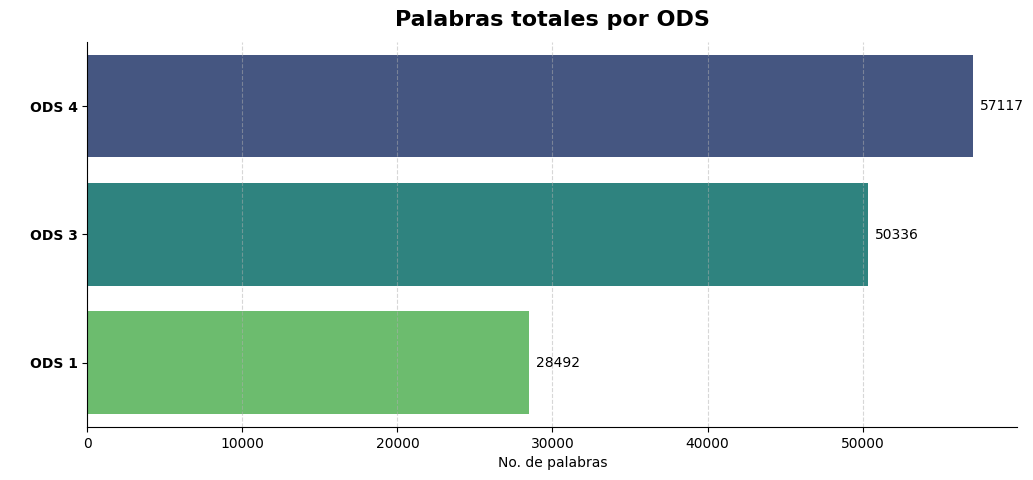

In [11]:
# Tamaño del grafico (x,y)................................................................
plt.figure(figsize=(12,5)) 
# Grafico.................................................................................
plt.ticklabel_format(style='plain', axis='y')  #Evita la notacion cientifica en el eje Y
ax = sns.countplot(data=df_tidy, y='labels', palette="viridis",
                   order=df['labels'].value_counts().index
)

# Estilo del grafico......................................................................
plt.title('Palabras totales por ODS', fontsize=16, loc="center",fontweight='bold', y=1.02)
plt.ylabel(' ')
plt.xlabel('No. de palabras')
plt.yticks(ticks=[0, 1, 2], labels=['ODS 4', 'ODS 3', 'ODS 1'],fontweight='bold')
sns.despine()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

for container in ax.containers:
    ax.bar_label(container, padding=5)

/var/folders/px/d5tv6q6n34qgfy_7vn7yfql80000gn/T/ipykernel_33092/3172092303.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=unique_tokens, y='labels', x='token', palette="viridis",orient='h',


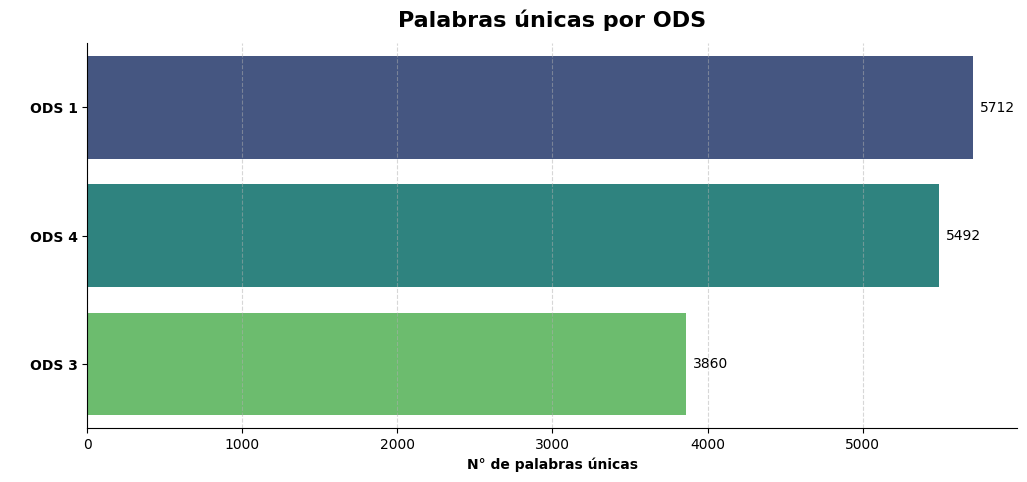

In [12]:
# Agrupamos y contamos tokens únicos por label
unique_tokens = df_tidy.groupby('labels')['token'].nunique().reset_index()
# Ordenar de mayor a menor
unique_tokens = unique_tokens.sort_values('token', ascending=False)
# Grafico.................................................................................
plt.figure(figsize=(12,5)) 
ax = sns.barplot(data=unique_tokens, y='labels', x='token', palette="viridis",orient='h',
                 order=unique_tokens['labels'])

# Estilo
plt.title('Palabras únicas por ODS', fontsize=16, fontweight='bold', y=1.02)
plt.ylabel(' ')
plt.xlabel('N° de palabras únicas', fontweight='bold')
plt.yticks(ticks=[0, 1, 2], labels=['ODS 1', 'ODS 4', 'ODS 3'],fontweight='bold')
sns.despine()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

# Etiquetas en cada barra
for container in ax.containers:
    ax.bar_label(container, padding=5)


### Longitud de textos:

In [13]:
# Longitud media y desviación de los textos por nivel
temp_df = pd.DataFrame(df_tidy.groupby(by = ["labels", "id"])["token"].count())
temp_df.reset_index().groupby("labels")["token"].agg(['mean', 'std']).round(2)

,mean,std
labels,,
1,56.42,18.57
3,56.30,18.62
4,55.72,18.00


In [14]:
# Top 5 palabras más utilizadas por cada nivel
df_tidy.groupby(['labels','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('labels') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

/var/folders/px/d5tv6q6n34qgfy_7vn7yfql80000gn/T/ipykernel_33092/3979846675.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('count', ascending=False).head(5))


labels       token  count
labels                                 
1      2834        1     pobreza   1004
       3386        1         ser    777
       2016        1     ingreso    363
       2739        1        país    351
       2832        1       pobre    313
3      8859        3         ser   1079
       8770        3       salud   1063
       4330        3    atención    820
       6476        3       haber    546
       8866        3    servicio    464
4      14357       4         ser   1165
       11559       4     escuela    888
       11346       4   educación    886
       11659       4  estudiante    758
       12112       4       haber    567

### Vectorización de textos:

Se limita el vocabulario a las 5000 palabras más frecuentes y se convierte el texto a vectores usando Tf-Idf

In [15]:
vectorizer_ngram = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X = vectorizer_ngram.fit_transform(df['texto_limpio'])
y = df['labels']

print("Forma de la nueva matriz de características (X):", X.shape)

Forma de la nueva matriz de características (X): (2424, 5000)


### Division de los datos (Test, Train):

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,   
    random_state=42,  
    stratify=y        
)

print("Distribución de clases en el conjunto de entrenamiento (antes de SMOTE):")
print(y_train.value_counts())

Distribución de clases en el conjunto de entrenamiento (antes de SMOTE):
labels
4    820
3    715
1    404
Name: count, dtype: int64


In [17]:
smote = SMOTE(random_state=42)

# Aplicar SMOTE solo a los datos de entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Forma de X_train antes de SMOTE:", X_train.shape)
print("Forma de X_train después de SMOTE:", X_train_smote.shape)

print(pd.Series(y_train_smote).value_counts())

Forma de X_train antes de SMOTE: (1939, 5000)
Forma de X_train después de SMOTE: (2460, 5000)
labels
3    820
1    820
4    820
Name: count, dtype: int64


## Modelado

Los modelos escogidos fueron los siguientes:
- Regresión Logística
- Bayes Multinomial
- Support Vector Machine (SVC)

In [18]:
# =============================================================================
# 1. BÚSQUEDA PARA REGRESIÓN LOGÍSTICA
# =============================================================================

pipeline_lr = Pipeline([
    ('smote', smote),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

# 'classifier__C' se refiere al parámetro 'C' del paso 'classifier'
parameters_lr = {
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print(f"Mejor F1-score para LR: {grid_search_lr.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_lr.best_params_}\n")


# =============================================================================
# 2. BÚSQUEDA PARA NAIVE BAYES MULTINOMIAL
# =============================================================================
print("--- Iniciando GridSearchCV para Naive Bayes ---")

pipeline_nb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', MultinomialNB())
])

# Naive Bayes tiene un parámetro principal: 'alpha' (suavizado)
parameters_nb = {
    'classifier__alpha': [0.1, 0.5, 1.0]
}

grid_search_nb = GridSearchCV(pipeline_nb, parameters_nb, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_nb.fit(X_train, y_train)

print(f"Mejor F1-score para NB: {grid_search_nb.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_nb.best_params_}\n")


# =============================================================================
# 3. BÚSQUEDA PARA SUPPORT VECTOR MACHINE (LINEAR SVC)
# =============================================================================
print("--- Iniciando GridSearchCV para SVM (LinearSVC) ---")

pipeline_svc = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(random_state=42, max_iter=5000))
])

# El parámetro clave de LinearSVC es 'C' (penalización del error)
parameters_svc = {
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_svc = GridSearchCV(pipeline_svc, parameters_svc, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train, y_train)

print(f"Mejor F1-score para SVM: {grid_search_svc.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_svc.best_params_}\n")


# Encontrar el mejor
scores = {
    'Logistic Regression': grid_search_lr.best_score_,
    'Naive Bayes': grid_search_nb.best_score_,
    'SVM (LinearSVC)': grid_search_svc.best_score_
}

# Encontrar el modelo con el mejor score
best_model_name = max(scores, key=scores.get)
print(f"El mejor modelo es: {best_model_name} con un F1-score de {scores[best_model_name]:.4f}")

# Guardar el mejor modelo para usarlo después
if best_model_name == 'Logistic Regression':
    best_model = grid_search_lr.best_estimator_
elif best_model_name == 'Naive Bayes':
    best_model = grid_search_nb.best_estimator_
else:
    best_model = grid_search_svc.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor F1-score para LR: 0.9742
Mejores parámetros: {'classifier__C': 1}

--- Iniciando GridSearchCV para Naive Bayes ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor F1-score para NB: 0.9686
Mejores parámetros: {'classifier__alpha': 0.1}

--- Iniciando GridSearchCV para SVM (LinearSVC) ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor F1-score para SVM: 0.9747
Mejores parámetros: {'classifier__C': 0.1}

El mejor modelo es: SVM (LinearSVC) con un F1-score de 0.9747


## Evaluación

  Resultados Finales: Regresión Logística
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.96      0.94      0.95       101
    ODS 3 (Salud)       0.97      0.97      0.97       179
ODS 4 (Educación)       0.97      0.98      0.98       205

         accuracy                           0.97       485
        macro avg       0.97      0.96      0.96       485
     weighted avg       0.97      0.97      0.97       485



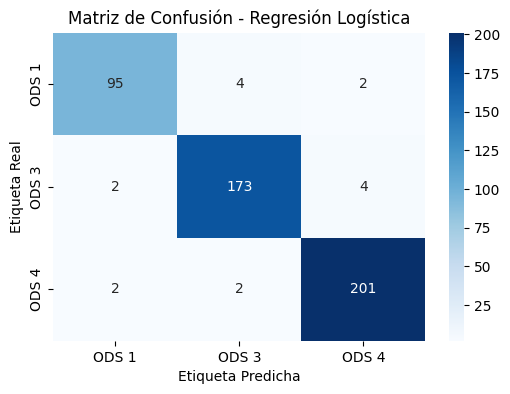


    Resultados Finales: Naive Bayes
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.94      0.97      0.96       101
    ODS 3 (Salud)       0.95      0.97      0.96       179
ODS 4 (Educación)       0.98      0.96      0.97       205

         accuracy                           0.96       485
        macro avg       0.96      0.96      0.96       485
     weighted avg       0.96      0.96      0.96       485



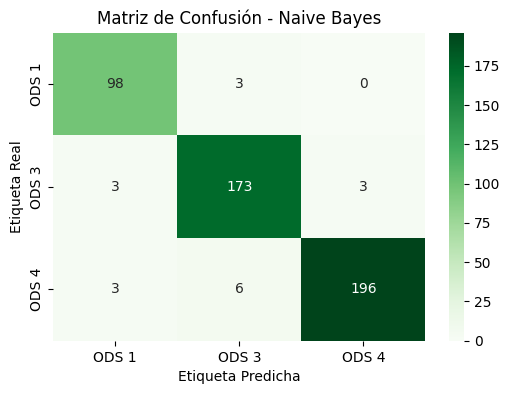


     Resultados Finales: SVM (LinearSVC)
                   precision    recall  f1-score   support

  ODS 1 (Pobreza)       0.96      0.96      0.96       101
    ODS 3 (Salud)       0.98      0.96      0.97       179
ODS 4 (Educación)       0.97      0.98      0.97       205

         accuracy                           0.97       485
        macro avg       0.97      0.97      0.97       485
     weighted avg       0.97      0.97      0.97       485



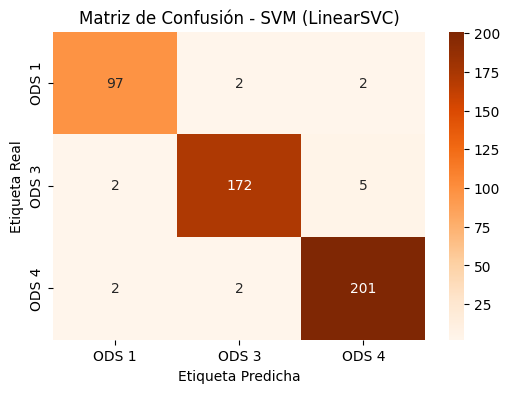

In [19]:
best_lr_model = grid_search_lr.best_estimator_
best_nb_model = grid_search_nb.best_estimator_
best_svc_model = grid_search_svc.best_estimator_


# --- 1. Evaluación de Regresión Logística ---
print("="*40)
print("  Resultados Finales: Regresión Logística")
print("="*40)
y_pred_lr = best_lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


# --- 2. Evaluación de Naive Bayes ---
print("\n" + "="*40)
print("    Resultados Finales: Naive Bayes")
print("="*40)
y_pred_nb = best_nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - Naive Bayes')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


# --- 3. Evaluación de SVM (LinearSVC) ---
print("\n" + "="*40)
print("     Resultados Finales: SVM (LinearSVC)")
print("="*40)
y_pred_svc = best_svc_model.predict(X_test)
print(classification_report(y_test, y_pred_svc, target_names=['ODS 1 (Pobreza)', 'ODS 3 (Salud)', 'ODS 4 (Educación)']))

# Matriz de confusión
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['ODS 1', 'ODS 3', 'ODS 4'], 
            yticklabels=['ODS 1', 'ODS 3', 'ODS 4'])
plt.title('Matriz de Confusión - SVM (LinearSVC)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

## Resultados

In [20]:
final_predictions = best_model.predict(X_test)

df_resultados = pd.DataFrame({
    'textos': df.loc[y_test.index, 'textos'],
    'labels_reales': y_test,
    'labels_predichas': final_predictions
})

output_filename = 'data/predicciones_grupo_16.xlsx'
df_resultados.to_excel(output_filename, index=False)

display(df_resultados.head())

,textos,labels_reales,labels_predichas
102,La relación entre el estatus étnico y el consu...,3,3
1220,"En los países de la OCDE, por cada reducción d...",3,3
233,Una segunda etapa de seguimiento ocurre a los ...,4,4
2056,La persona respetable más pobre de cualquier s...,1,1
698,En ellos se basan las publicaciones anuales co...,4,4


In [22]:
def mostrar_palabras_clave(model_pipeline, vectorizer, top_n=20, words_per_row=5):
    classifier = model_pipeline.named_steps["classifier"]
    feature_names = vectorizer.get_feature_names_out()

    # Coeficientes por palabra
    coefs_por_clase = classifier.coef_

    # Palabras más importantes para cada clase
    for i, class_label in enumerate(classifier.classes_):
        coefs = coefs_por_clase[i]
        top_coef_indices = coefs.argsort()[-top_n:]

        top_words = [feature_names[j] for j in top_coef_indices][::-1]

        print(f"--- ODS {class_label} ---")
        # Print in chunks of `words_per_row`
        for k in range(0, len(top_words), words_per_row):
            print(", ".join(top_words[k : k + words_per_row]))
        print("")


print("Palabras más influyentes por ODS:")
mostrar_palabras_clave(best_model, vectorizer_ngram)

Palabras más influyentes por ODS:
--- ODS 1 ---
pobreza, pobre, hogar, ingreso, social
privación, protección social, protección, empleo, crecimiento
transferencia, niño, vivir, familia, urbano
umbral, multidimensional, trabajo, vivienda, pobreza infantil

--- ODS 3 ---
salud, atención, médico, enfermedad, paciente
sanitario, mortalidad, alcohol, mental, tratamiento
droga, hospital, servicio, medicamento, consumo
atención primario, cáncer, muerte, hospitalario, vih

--- ODS 4 ---
educación, escuela, estudiante, educativo, docente
aprendizaje, escolar, alumno, profesor, habilidad
enseñanza, maestro, evaluación, formación, universidad
superior, ciencia, sistema educativo, personal, pisa

